In [3]:
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
import dask.array as da
from glob import glob

filenames = sorted(glob(r"C:\dev\GitLab\3d-quantification\Data\gaba\*.tif"), key=alphanumeric_key)
# read the first file to get the shape and dtype
# ASSUMES THAT ALL FILES SHARE THE SAME SHAPE/TYPE
sample = imread(filenames[0])

lazy_imread = delayed(imread)  # lazy reader
lazy_arrays = [lazy_imread(fn) for fn in filenames]
dask_arrays = [
    da.from_delayed(delayed_reader, shape=sample.shape, dtype=sample.dtype)
    for delayed_reader in lazy_arrays
]
# Stack into one large dask.array
stack = da.stack(dask_arrays, axis=0)
stack.shape  # (nfiles, nz, ny, nx)

# in jupyter notebook the repr of a dask stack provides a useful visual:
stack

dask.array<stack, shape=(37, 1024, 1024), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

In [344]:
import napari
from napari_plugin_engine import napari_hook_implementation
import numpy as np
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu as sk_threshold_otsu, gaussian
from skimage.segmentation import watershed
from skimage.measure import label
from skimage.morphology import local_maxima

def voronoi_otsu_labeling(image:"napari.types.ImageData", spot_sigma: float = 2, outline_sigma: float = 2) -> "napari.types.LabelsData":

    image = np.asarray(image)

    # blur and detect local maxima
    blurred_spots = gaussian(image, spot_sigma)
    spot_centroids = local_maxima(blurred_spots)

    # blur and threshold
    blurred_outline = gaussian(image, outline_sigma)
    threshold = sk_threshold_otsu(blurred_outline)
    binary_otsu = blurred_outline > threshold

    # determine local maxima within the thresholded area
    remaining_spots = spot_centroids * binary_otsu

    # start from remaining spots and flood binary image with labels
    labeled_spots = label(remaining_spots)
    labels = watershed(binary_otsu, labeled_spots, mask=binary_otsu)

    return labels

In [345]:
import numpy as np
spacing = np.array([1, 1, 1])

In [346]:
from dask_image.imread import imread
from scipy import ndimage as ndi
import napari
from skimage.segmentation import watershed

VGaT = imread(r"C:\dev\GitLab\3d-quantification\Data\gaba\*.tif")
viewer = napari.view_image(
    VGaT,
    scale=spacing,
    contrast_limits=[0, 2000],
    multiscale=False
)

In [347]:
VGaT_labels = voronoi_otsu_labeling(VGaT, spot_sigma = 0.5, outline_sigma = 1)

VGaT_labels_viewer = viewer.add_labels(
    VGaT_labels,
    scale=spacing,
)

In [348]:
VGluT3 = imread(r"C:\dev\GitLab\3d-quantification\Data\glu\*.tif")
viewer.add_image(
    VGluT3,
    scale=spacing,
    contrast_limits=[0, 2000],
    multiscale=False
)
VGluT3_lables = voronoi_otsu_labeling(VGluT3)

VGluT3_lables_viewer = viewer.add_labels(
    VGluT3_lables,
    scale=spacing,
)

In [349]:
lables_overlap = VGluT3_lables & VGaT_labels


In [350]:
labels_colocal_viewer = viewer.add_labels(
    lables_overlap,
    scale=spacing,
)


In [351]:
VGaT_overlap = VGaT_labels & lables_overlap

# ANALYSIS

In [352]:
import pandas as pd
from skimage.measure import regionprops_table

# measure the voxel counts
measurements_table = regionprops_table(lables_overlap, properties=['label', 'area', 'coords'])

# convert to a dataframe
measurements_df = pd.DataFrame(measurements_table)
measurements_df

KeyboardInterrupt: 

In [ ]:

measurements_table = regionprops_table(VGaT_overlap, properties=['label', 'area'])

# convert to a dataframe
measurements_df = pd.DataFrame(measurements_table)
measurements_df

,label,area
0,1,5415
1,2,6134
2,3,3195
3,4,6419
4,5,2198
...,...,...
1361,3440,1
1362,3448,95
1363,3454,17
1364,3455,103


In [ ]:
measurements_table = regionprops_table(VGluT3_lables, properties=['label', 'area', 'coords'])

# convert to a dataframe
measurements_df = pd.DataFrame(measurements_table)
measurements_df

,label,area,coords
0,1,9,"[[0, 0, 115], [0, 0, 116], [0, 0, 117], [0, 0,..."
1,2,174,"[[0, 0, 784], [0, 0, 785], [0, 0, 786], [0, 0,..."
2,3,62,"[[0, 0, 485], [0, 0, 486], [0, 0, 487], [0, 0,..."
3,4,588,"[[0, 0, 524], [0, 0, 525], [0, 0, 526], [0, 0,..."
4,5,182,"[[0, 3, 478], [0, 4, 477], [0, 4, 478], [0, 4,..."
...,...,...,...
12505,12506,251,"[[28, 1023, 207], [28, 1023, 208], [29, 1021, ..."
12506,12507,345,"[[28, 1023, 274], [28, 1023, 275], [28, 1023, ..."
12507,12508,254,"[[29, 1019, 674], [29, 1019, 675], [30, 1018, ..."
12508,12509,85,"[[30, 1023, 726], [30, 1023, 727], [31, 1022, ..."


In [ ]:
# measure the voxel counts
measurements_table2 = regionprops_table(VGaT_labels, properties=['label', 'area', 'coords'])

# convert to a dataframe
measurements_df2 = pd.DataFrame(measurements_table2)
measurements_df2

,label,area,coords
0,1,30,"[[0, 20, 222], [0, 20, 223], [0, 20, 224], [0,..."
1,2,71,"[[0, 20, 501], [0, 21, 500], [0, 21, 501], [0,..."
2,3,531,"[[0, 20, 775], [0, 20, 776], [0, 21, 774], [0,..."
3,4,188,"[[0, 31, 123], [0, 31, 124], [0, 32, 123], [0,..."
4,5,86,"[[0, 34, 574], [0, 34, 575], [0, 35, 573], [0,..."
...,...,...,...
3487,3488,127,"[[31, 999, 444], [31, 1000, 443], [31, 1000, 4..."
3488,3489,140,"[[32, 1008, 244], [32, 1008, 245], [32, 1008, ..."
3489,3490,2,"[[36, 1011, 256], [36, 1012, 256]]"
3490,3491,15,"[[35, 1013, 938], [35, 1013, 939], [35, 1014, ..."


In [ ]:
gaba = measurements_df[measurements_df.area >= 10]
glu = measurements_df2[measurements_df2.area >= 10]

In [ ]:
glu_max = glu.label.max()
gaba_max = gaba.label.max()
maxd =[["Transporter","Amount"],
["VGaT",3492],
["VGluT3",12510]]
maxd=pd.DataFrame(maxd)
new_header = maxd.iloc[0] #grab the first row for the header
maxd = maxd[1:] #take the data less the header row
maxd.columns = new_header
max = maxd
max

,Transporter,Amount
1,VGaT,3492
2,VGluT3,12510


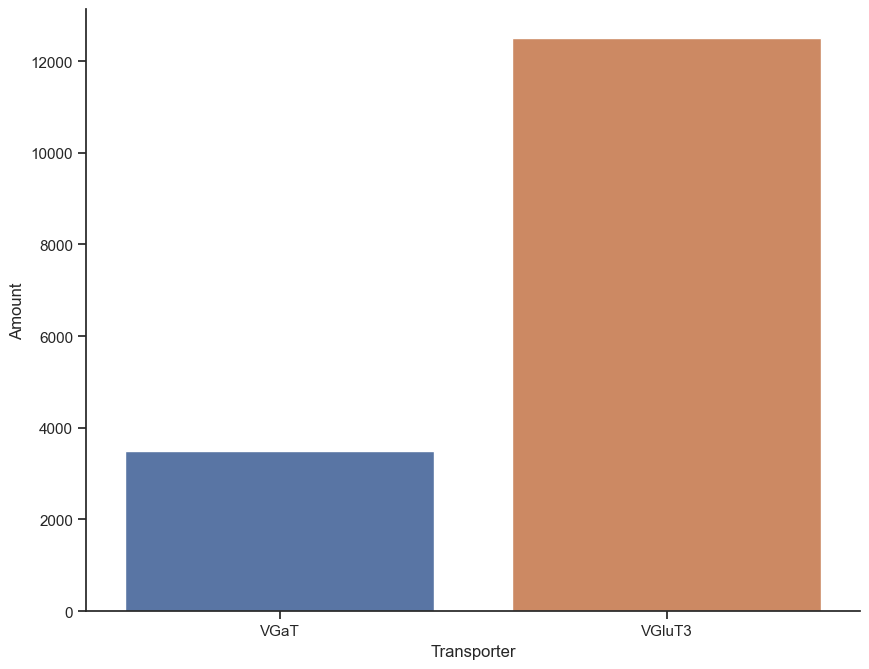

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

fig = plt.figure(figsize=(10, 8))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

custom_params = {"axes.spines.right": False, "axes.spines.top": False,'figure.figsize':(10,10), 'font.size':50}
sns.set_theme(style="ticks", rc=custom_params)

sns.barplot(x="Transporter",y="Amount",data=max)
#change_width(fig, .35)
plt.tight_layout()